<a href="https://colab.research.google.com/github/imkhubaibraza/MSDS19064_COVID19_DLSpring2020/blob/master/Final_covid_task_02_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Initilization Notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Importing libraries

In [0]:
# !unzip -q "/content/drive/My Drive/DL-05/part-02/A_05_Part_02_Dataset.zip" -d "data"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix,\
                            f1_score,multilabel_confusion_matrix,\
                            accuracy_score,precision_score,hamming_loss
import warnings

from torch.utils.data import Dataset
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Loadaing Data Set

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = '/content/drive/My Drive/DL-05/dataset2/A_05_Part_02_Dataset'
#transforming data of train validation and test data
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
val_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
#pass transform here-in
train_data = datasets.ImageFolder(data_path + '/Train', transform=train_transforms)
val_data = datasets.ImageFolder(data_path +'/Validation',transform=val_transforms )
test_data = datasets.ImageFolder(data_path + '/Test', transform=val_transforms)
#data loaders
trainloader = torch.utils.data.DataLoader(train_data , num_workers=4,batch_size = 60,shuffle=True)
testloader = torch.utils.data.DataLoader(test_data,num_workers=4,batch_size = 100,shuffle=True)
valloader = torch.utils.data.DataLoader(val_data ,num_workers=4,batch_size = 100,shuffle = True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


### Data Visualize

In [0]:
def total_dataset():
    len_train = len(train_data)
    # len_test = len(test_data)
    len_valid = len(val_data)

    print("Train Data:",len_train," validation_data :",len_valid)

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.01)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    plt.figure(figsize=(15,8))
    imshow(out, title=('                              ')\
           .join([class_names[x] for x in classes]))
    


Train Data: 6200  validation_data : 628


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


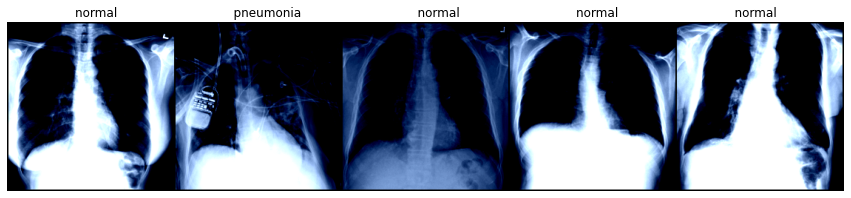

In [7]:
total_dataset()
# Get a batch of training data
inputs, classes = next(iter(valloader))
show_databatch(inputs[:5], classes[:5])

### User-Defined Functions

In [0]:
#Now we fereze the parameters
def freeze_all_params(model_):
    for param in model_.parameters():
        param.requires_grad = False

def parameters_show(model_):
    for name, param in model_.named_parameters():
        if param.requires_grad:
            print(name)

#plot accuracies curves using train history or test history
def train_valid_loss_curve(total_train_loss,total_valid_loss):
    plt.plot(total_train_loss)
    plt.plot(total_valid_loss)
    plt.legend(['Training Loss','Validation Loss'])
    plt.title('Loss Curve over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.show()

#plot accuracies curves using train history or test history

def train_valid_accuracy_curve(accuracy_train_history , accuracy_valid_history):

    plt.title('Accuracy of Model')
    plt.plot(accuracy_train_history, label='train')
    plt.plot(accuracy_valid_history, label='Validate')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def convert_multi_encode(labels_encode):
    temp_list = []
    for i,temp1 in enumerate(labels_encode):
        if temp1 == 0:
            temp = [1,0,1]
        elif temp1 == 1:
            temp = [0,1,0]
        else:
            temp = [0,0,1]
        temp_list.append(temp)
    new_labels = torch.from_numpy(np.array(temp_list)).cuda()
    return new_labels


def compute_csv_test(model_,testingloader):

    temp_array = []
    temp_images = []
    with torch.no_grad():
        for data in testingloader:
            images, labels = data
            
            # labels = convert_multi_encode(labels)
            images = images.to(device)

            outputs = model_(images)
            predicted = torch.round(torch.sigmoid(outputs))

            pred = predicted[:, [0, 2, 1]] # Swapped columns of Normal to Pheneomonia
            # for x in range():
            # allArrays = np.concatenate([temp_array, pred.cpu()],axis = 0)
            temp_array.append(pred.cpu())
    return temp_array


Create Csv file

In [0]:
predication , image_names = compute_csv_test(resnet18 , valloader)
predication = np.array([np.array(xi.cpu()) for xi in predication])
predication = np.vstack(predication)

df = pd.DataFrame(predictions)
df[3] = image_names
df = df[[3, 0, 1, 2]]
df.to_csv('sample.csv',index=False , header=False)

100

#### Model Testing function

In [0]:
def compute_accuracy_test(model_,testingloader):
    correct = 0
    total = 0
    pred_list = []
    label_list = []

    with torch.no_grad():
        for data in testingloader:
            images, labels = data
            
            labels = convert_multi_encode(labels)
            images, labels = images.to(device), labels.to(device)

            outputs = model_(images)
            predicted = torch.round(torch.sigmoid(outputs))
            # print(predicted)
            total += labels.size(0)
            correct += ((predicted == labels).all(axis=1)).sum().item()
            

            label_list.append(labels)
            pred_list.append(predicted)
    acc = 100 * correct / total
    print('Accuracy of the network on test images:' , (acc))
    return pred_list,label_list

def conf_matrix(label , predication):
    #Getting the confusion matrix
    label = np.array([np.array(xi.cpu()) for xi in label])
    label = np.vstack(label)
    predication=np.array([np.array(xi.cpu()) for xi in predication])
    predication = np.vstack(predication)

    ham_score = hamming_loss(label, predication)
    mat = multilabel_confusion_matrix(label, predication)
    print("hamming loss:" ,ham_score)
    # print(confusion_matrix(label, predication))
    # prec_score = precision_score(label, predication ,average='weighted')
    F1_score = f1_score(label, predication ,average='weighted')
    print("f1_score:",F1_score)
    return mat
    
# compute_accuracy_test(vgg16,valloader)
# print(conf_matrix(label_list , pred_list))

###### Defined Loss Function

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.7, gamma=1.7):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss) #
        focal_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(focal_loss)

#### Model Training Methood

In [0]:
def model_training(model_ ,trainingloader, validationloader, Epochs = 1 ,\
                   model_save_path = '/sample.pth',learning_rate = 0.001 ,
                   alpha = 1 , gamma =0 , focal_loss = True ):

    #first time init model
    if not os.path.exists(model_save_path):
        total_valid_loss = []
        total_train_loss = []
        total_valid_accuracy = []
        total_train_accuracy = []
    else: # loading models params
        print("loading")
        com_model = torch.load(model_save_path)
        model_.load_state_dict(com_model['model'])

        total_valid_loss = com_model['total_valid_loss']
        total_train_loss = com_model['total_train_loss']
        total_valid_accuracy = com_model['total_valid_accuracy']
        total_train_accuracy = com_model['total_train_accuracy']

    criterion = FocalLoss(alpha, gamma )
    optimizer = optim.Adam(model_.parameters())

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model_.to(device)
    model_.train()

    for epoch in range(Epochs):  

        correct = 0
        total = 0
        running_loss = 0.0
        bar = tqdm(enumerate(trainingloader))
        
        print("************* Epoch: %d" %epoch,"***************" )

        for i, data in bar:
            
            inputs,labels = data
            labels = convert_multi_encode(labels)
            inputs, labels = inputs.float().cuda() , labels

            optimizer.zero_grad()
            outputs = model_(inputs)  

            labels = labels.type_as(outputs)

            loss = criterion(outputs.float(), labels)   #----> compute loss

            loss.backward()                     #----> backward pass
            running_loss += loss.item()
            
            optimizer.step()                    #----> weights update
            bar.set_description(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),loss.data.item()))
            

            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += ((predicted == labels).all(axis=1)).sum().item()
            # break
        epoch_train_loss = running_loss/len(trainingloader)
        epoch_train_acc = 100 * correct / total

        print("\nloss : ",epoch_train_loss, "accuracy:",epoch_train_acc)

        total_train_loss.append(epoch_train_loss)
        total_train_accuracy.append(epoch_train_acc)

        # print(outputs)
        correct = 0
        total = 0
        running_loss = 0.0

        print('validation started....')
        with torch.no_grad():
            for data in validationloader:
                inputs,labels = data
                labels = convert_multi_encode(labels)
                inputs, labels = inputs.float().cuda() , labels

                optimizer.zero_grad()
                outputs = model_(inputs)  

                labels = labels.type_as(outputs)

                test_loss = criterion(outputs, labels)
                running_loss += test_loss.item()
                
                predicted = torch.round(torch.sigmoid(outputs))
                # _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += ((predicted == labels).all(axis=1)).sum().item()
                # break
        epoch_val_loss = running_loss/len(validationloader)
        epoch_val_acc = 100 * correct / total

        print("\nloss : ",epoch_val_loss, "accuracy:",epoch_val_acc)

        total_valid_loss.append(epoch_val_loss)
        total_valid_accuracy.append(epoch_val_acc)
        # print(outputs)

    print('Finished Training')

    params_dict = {'model':model_.state_dict(),\
               'total_train_loss':total_train_loss,\
               'total_valid_loss':total_valid_loss,\
               'total_train_accuracy':total_train_accuracy,\
               'total_valid_accuracy':total_valid_accuracy,\
               'Epochs':Epochs}
    torch.save(params_dict, model_save_path)

    train_valid_loss_curve(total_train_loss , total_valid_loss)
    train_valid_accuracy_curve(total_train_accuracy, total_valid_accuracy)

##*Downloading* Pretrained Models

In [24]:
resnet18 = models.resnet18(pretrained=True) # pretrained model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [8]:
vgg16 = models.vgg16(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


## Resnet Task 1


##### Define FC layers

In [0]:
#now fine tunning (Last 2 digits of your roll number x 10) + 100
# (64 *10)+100 model saved with these values
# remove last pretrained feature
num_features = resnet18.fc.in_features
features = list(resnet18.fc.children())[:-1]

num_hidden = 256
# features.extend([nn.Linear(num_features, num_hidden) , nn.Linear(num_hidden, len(class_names))])

features.extend([nn.Linear(num_features, num_hidden),
                    nn.ReLU(), 
                    nn.Dropout(0.3),
                    nn.BatchNorm1d(num_hidden),
                    nn.Linear(num_hidden, len(class_names))])

resnet18.fc = nn.Sequential(*features)
# print(resnet18)

##### Task-01 with CrossEntropy **Binary** Loss

cuda:0
loading


************* Epoch: 0 ***************


loss :  0.10438498410467918 accuracy: 93.70967741935483
validation started....

loss :  0.11098123182143484 accuracy: 94.26751592356688


************* Epoch: 1 ***************


loss :  0.09336035763128446 accuracy: 94.08064516129032
validation started....

loss :  0.13706880834485805 accuracy: 94.10828025477707
Finished Training


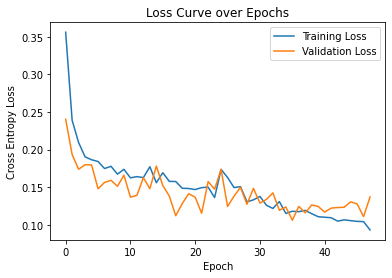

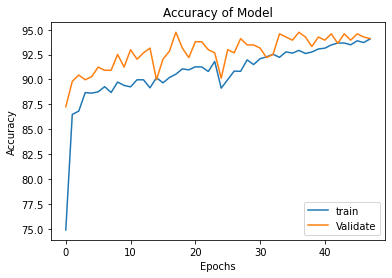

In [125]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # check for GPU avaliable
print(device)
epcohs = 2
model_path = '/content/drive/My Drive/DL-05/part-02'
# calling function 
model_training(resnet18 , \
               trainloader,\
               valloader,\
               Epochs = epcohs ,\
               model_save_path = model_path+'/resnet18_woo_focal.pth', \
               learning_rate = 0.001 )

##### Task-02 with Focal Loss

cuda:0
loading


************* Epoch: 0 ***************


loss :  0.014671263383486522 accuracy: 91.93548387096774
validation started....

loss :  0.014715977944433689 accuracy: 93.78980891719745


************* Epoch: 1 ***************


loss :  0.014816846644792419 accuracy: 91.80645161290323
validation started....

loss :  0.016229286656848023 accuracy: 93.78980891719745


************* Epoch: 2 ***************


loss :  0.014878820341366988 accuracy: 91.93548387096774
validation started....

loss :  0.013804183541131871 accuracy: 92.99363057324841
Finished Training


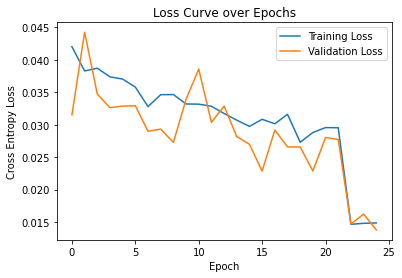

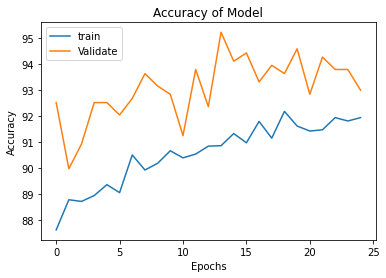

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # check for GPU avaliable
print(device)
epcohs = 3
model_path = '/content/drive/My Drive/DL-05/part-02/'
# calling function 
model_training(resnet18 , \
               trainloader,\
               valloader,\
               Epochs = epcohs ,\
               model_save_path = model_path+'/resnet18_focal4.pth', \
               learning_rate = 0.001,\
               alpha = 0.3,
               gamma =1.5,
               focal_loss = True)

cuda:0
loading


************* Epoch: 0 ***************


loss :  0.009360000329951827 accuracy: 92.93548387096774
validation started....

loss :  0.01556812007246273 accuracy: 93.63057324840764
Finished Training


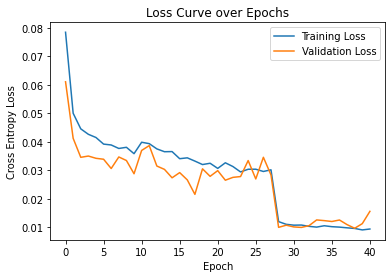

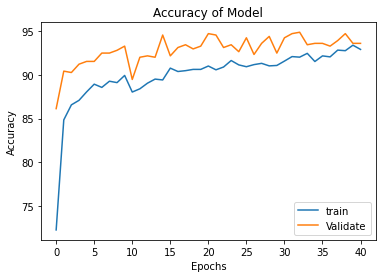

In [93]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # check for GPU avaliable
print(device)
epcohs = 1
model_path = '/content/drive/My Drive/DL-05/part-02/'
# calling function 
model_training(resnet18 , \
               trainloader,\
               valloader,\
               Epochs = epcohs ,\
               model_save_path = model_path+'/resnet18_focal3.pth', \
               learning_rate = 0.001,\
               alpha = 0.3,
               gamma =2,
               focal_loss = True)

In [0]:
# Best Accuracies saved on epochs
# '/resnet18_focal1.pth' 10 epochs 93 max
# /vgg16_focal 15 epochs max 88
# /vgg16_focal1.pth' 30 epochs max 90

#Just loading already saved model

model_path = '/content/drive/My Drive/DL-05/part-02/resnet18_focal4.pth'
print("loading")
com_model = torch.load(model_path)
resnet18.load_state_dict(com_model['model'])

total_valid_loss = com_model['total_valid_loss']
total_train_loss = com_model['total_train_loss']
total_valid_accuracy = com_model['total_valid_accuracy']
total_train_accuracy = com_model['total_train_accuracy']

loading


In [0]:
predication  = compute_csv_test(resnet18 , testloader)

In [0]:
image_names = []
for i in range(len(test_data)):
    image_names.append(testloader.dataset.samples[i][0].split('/')[-1].split('.')[0])

In [0]:
# image_names

In [0]:
predication = np.array([np.array(xi) for xi in predication])
predication = np.vstack(predication)

df = pd.DataFrame(predication)
df[3] = image_names
df = df[[3, 0, 1, 2]]
df.to_csv('sample1.csv',index=False , header=False)

In [0]:
# df[200:250]

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # check for GPU avaliable

##### Focal Loss

In [131]:
model_path = '/content/drive/My Drive/DL-05/part-02/resnet18_focal4.pth'
print("loading")
com_model = torch.load(model_path)
resnet18.load_state_dict(com_model['model'])

total_valid_loss = com_model['total_valid_loss']
total_train_loss = com_model['total_train_loss']
total_valid_accuracy = com_model['total_valid_accuracy']
total_train_acuracy = com_model['total_train_accuracy']

loading


In [0]:
label_list , pred_list = compute_accuracy_test(resnet18,valloader)
print(conf_matrix(label_list , pred_list))

0.9394904458598726
hamming loss: 0.042993630573248405
[[[598   2]
  [  9  19]]

 [[209  19]
  [ 16 384]]

 [[384  16]
  [ 19 209]]]


In [132]:
label_list , pred_list = compute_accuracy_test(resnet18,trainloader)
print(conf_matrix(label_list , pred_list))

Accuracy of the network on test images: 92.35483870967742
hamming loss: 0.047688172043010756
f1_score: 0.9324205365918905
[[[5979   98]
  [  21  102]]

 [[1958  143]
  [ 242 3857]]

 [[3859  242]
  [ 141 1958]]]


##### Without Focal Loss

In [115]:
model_path = '/content/drive/My Drive/DL-05/part-02/resnet18_woo_focal.pth'
print("loading")
com_model = torch.load(model_path)
resnet18.load_state_dict(com_model['model'])

total_valid_loss = com_model['total_valid_loss']
total_train_loss = com_model['total_train_loss']
total_valid_accuracy = com_model['total_valid_accuracy']
total_train_acuracy = com_model['total_train_accuracy']

loading


In [129]:
label_list , pred_list = compute_accuracy_test(resnet18,valloader)
print(conf_matrix(label_list , pred_list))

Accuracy of the network on test images: 94.10828025477707
hamming loss: 0.042993630573248405
f1_score: 0.9397798199924443
[[[600  11]
  [  0  17]]

 [[202   9]
  [ 26 391]]

 [[391  26]
  [  9 202]]]


In [0]:
label_list , pred_list = compute_accuracy_test(renset18,trainloader)
print(conf_matrix(label_list , pred_list))

## VGG16 *Task1*

In [11]:
# download pretrained using torch vision
vgg16 = models.vgg16(pretrained = True)
# Make parametrs update False
for param in vgg16.features.parameters():
    param.requires_grad = True
    # if param

# remove last layer of model and count number of parametrs
num_features = vgg16.classifier[-1].in_features
features = list(vgg16.classifier.children())[:-1]
print(features)



# num_hidden1 = 1024
# features.extend([nn.Linear(num_features, num_hidden1),
#                     nn.ReLU( inplace=True ),
#                     nn.Dropout( p=0.5, inplace=False ),
#                     nn.Linear(num_hidden1, len(class_names))])

# features.extend([nn.Linear(num_features, num_hidden1),
#                     nn.ReLU(), 
#                     nn.Dropout(0.3),
#                     nn.BatchNorm1d(num_hidden1),
#                     nn.Linear(num_hidden1, len(class_names))])



# num_hidden1 = 1024
# num_hidden2 = 256

# features.extend([nn.Linear(num_features, num_hidden1),
#                     nn.ReLU( inplace=True ),
#                     nn.Dropout( p=0.5, inplace=False ),
#                     nn.Linear(num_hidden1, num_hidden2),
#                     nn.ReLU( inplace=True ),
#                     nn.Linear(num_hidden2, len(class_names))
#                  ])
num_hidden1 = 2000
num_hidden2 = 800
# features.extend([nn.Linear(num_features, num_hidden1),
#                     nn.Linear(num_hidden1, num_hidden2),
#                     nn.Linear(num_hidden2, len(class_names))])

features.extend([nn.Linear(num_features, num_hidden1),
                    nn.ReLU(), 
                    nn.Dropout(0.3),
                    nn.BatchNorm1d(num_hidden1),
                    nn.Linear(num_hidden1, len(class_names))])

#now add our own feature into Model
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

cuda:0
loading


************* Epoch: 0 ***************


loss :  0.35052779961663943 accuracy: 78.51612903225806
validation started....

loss :  0.32515754231384825 accuracy: 83.75796178343948


************* Epoch: 1 ***************


loss :  0.3192747010347935 accuracy: 80.38709677419355
validation started....

loss :  0.26735952709402355 accuracy: 85.828025477707


************* Epoch: 2 ***************


loss :  0.32141192658589435 accuracy: 80.40322580645162
validation started....

loss :  0.3278088654790606 accuracy: 85.19108280254777


************* Epoch: 3 ***************


loss :  0.30592090937380606 accuracy: 82.12903225806451
validation started....

loss :  0.24641951279980795 accuracy: 85.50955414012739


************* Epoch: 4 ***************


loss :  0.30340978188010365 accuracy: 81.45161290322581
validation started....

loss :  0.23167280001299723 accuracy: 87.57961783439491
Finished Training
20


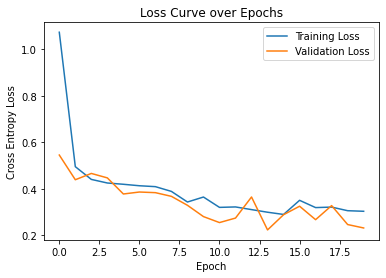

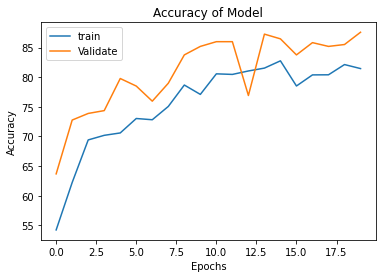

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # check for GPU avaliable
print(device)
epcohs = 5
model_path = '/content/drive/My Drive/DL-05/part-02'
# calling function 
model_training(vgg16 , \
               trainloader,\
               valloader,\
               Epochs = epcohs ,\
               model_save_path = model_path+'/vgg16_w1_focal.pth')


In [0]:
label_list , pred_list = compute_accuracy_test(vgg16,valloader)
print(conf_matrix(label_list , pred_list))

Accuracy of the network on test images: 84.23566878980891
hamming loss: 0.1173036093418259
f1_score: 0.8571109782217985
f1_score: 0.902414581764427
[[[600  28]
  [  0   0]]

 [[135   4]
  [ 93 396]]

 [[396  92]
  [  4 136]]]


In [0]:
confusion_matrix(actualt,predictiont)

hamming loss: 0.07908704883227176
f1_score: 0.904529697411556
f1_score: 0.9071860095389507
[[[600  28]
  [  0   0]]

 [[190  22]
  [ 38 378]]

 [[377  38]
  [ 23 190]]]


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # check for GPU avaliable
print(device)
epcohs = 15
model_path = '/content/drive/My Drive/DL-05/part-02'
# calling function 
model_training(vgg16 , \
               trainloader,\
               valloader,\
               Epochs = epcohs ,\
               model_save_path = model_path+'/vgg16_focal.pth', \
               learning_rate = 0.001,\
               alpha = 0.3,
               gamma = 2,
               focal_loss = True)

# /vgg16_1_focal.pth
# delete max 87 15 epochs  .3 and 1.3
# now 1.7 and 0.6

#### Load Saved Models

In [12]:
model_path = '/content/drive/My Drive/DL-05/part-02/vgg16_focal1.pth'
print("loading")
com_model = torch.load(model_path)
vgg16.load_state_dict(com_model['model'])

total_valid_loss = com_model['total_valid_loss']
total_train_loss = com_model['total_train_loss']
total_valid_accuracy = com_model['total_valid_accuracy']
total_train_accuracy = com_model['total_train_accuracy']

loading


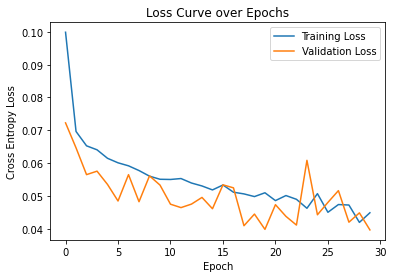

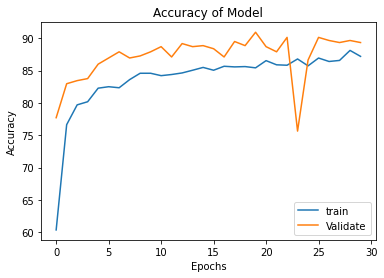

In [16]:
train_valid_loss_curve(total_train_loss , total_valid_loss)
train_valid_accuracy_curve(total_train_accuracy, total_valid_accuracy)

In [20]:
label_list , pred_list = compute_accuracy_test(vgg16.cuda(),valloader)
print(conf_matrix(label_list , pred_list))

Accuracy of the network on test images: 87.89808917197452
hamming loss: 0.06847133757961783
f1_score: 0.9111780509328042
[[[591  26]
  [  9   2]]

 [[202  21]
  [ 26 379]]

 [[379  26]
  [ 21 202]]]


In [22]:
label_list , pred_list = compute_accuracy_test(vgg16.cuda(),trainloader)
print(conf_matrix(label_list , pred_list))

Accuracy of the network on test images: 86.83870967741936
hamming loss: 0.07688172043010753
f1_score: 0.8933476878625976
[[[5928  182]
  [  72   18]]

 [[1978  367]
  [ 222 3633]]

 [[3635  222]
  [ 365 1978]]]


In [0]:
# array([[[597,   3],
#         [ 16,  12]],

#        [[195,  33],
#         [ 13, 387]],

#        [[387,  13],
#         [ 33, 195]]])

# Sofar best Resnet18 3rd
# array([[[598,   2],
#         [  9,  19]],

#        [[210,  18],
#         [ 17, 383]],

#        [[384,  16],
#         [ 18, 210]]])


# 0.93604033970276
# [[[599   1]
#   [ 10  18]]

#  [[205  23]
#   [ 17 383]]

#  [[383  17]
#   [ 23 205]]]



# [[[597   3]
#   [  7  21]]

#  [[201  27]
#   [  5 395]]

#  [[395   5]
#   [ 28 200]]]

# Resnet

# array([[[596,   4],
#         [  8,  20]],

#        [[200,  28],
#         [  3, 397]],

#        [[397,   3],
#         [ 28, 200]]])


